In [1]:
from roboflow import Roboflow
from dotenv import load_dotenv
import os

env_path = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.env"
load_dotenv(dotenv_path=env_path)
robo_token = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=robo_token)

project = rf.workspace("capjamesg").project("metal-defect-detection-d3wl6")
dataset = project.version(2).download("yolov8-obb")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Metal-Defect-Detection-2 in yolov8-obb:: 100%|██████████| 498/498 [00:00<00:00, 1599.98it/s]


In [ ]:
import yaml

with open(f'{dataset.location}/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['path'] = dataset.location

with open(f'{dataset.location}/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)

In [ ]:
!pip install "ultralytics<=8.3.40"

In [ ]:
from ultralytics import YOLO

model = YOLO(“yolov8n-obb.pt”)

results = model.train(data=f”{dataset.location}/yolov8-obb.yaml', epochs=100, imgsz=640)

In [ ]:
!pip install supervision

In [ ]:
model = YOLO('runs/obb/train2/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

import supervision as sv
import cv2

detections = sv.Detections.from_ultralytics(results[0])

oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=cv2.imread(file_name),
    detections=detections
)

sv.plot_image(image=annotated_frame, size=(16, 16))

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"../runs/detect/train2/")

View the status of your deployment at: https://app.roboflow.com/spencer-kmi6v/pool-detect-cnn/2
Share your model with the world at: https://universe.roboflow.com/spencer-kmi6v/pool-detect-cnn/model/2


In [ ]:
!pip install inference

Running inference on 253_png.rf.43e5f7d372f4d2c33715923d7cd55e2a.jpg


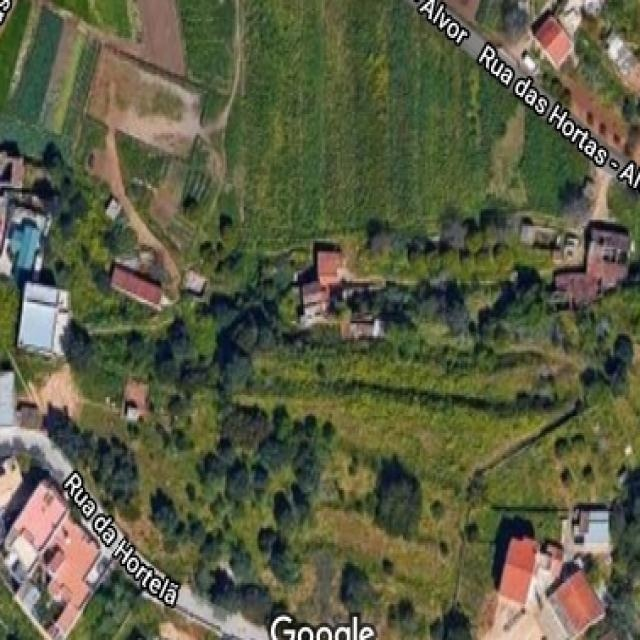

Running inference on 162_PNG.rf.e01bbd4a16290c37f63dfa86f2ec87af.jpg


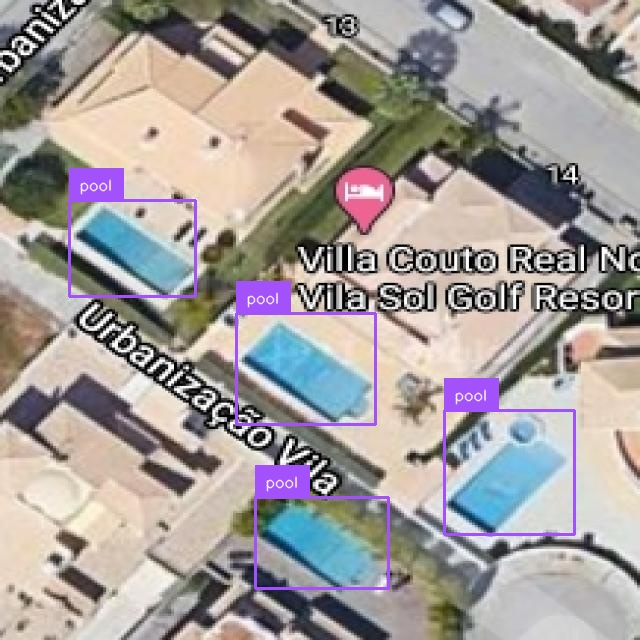

Running inference on 92_PNG.rf.30a6d3681e61742e6cec5b2a57e62d4f.jpg


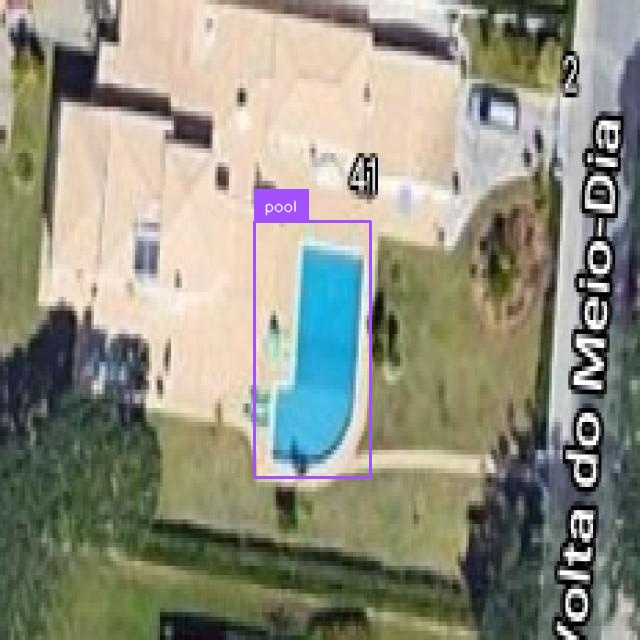

Running inference on 111_PNG.rf.9b45c26604f5c59c4219cd5543aa56be.jpg


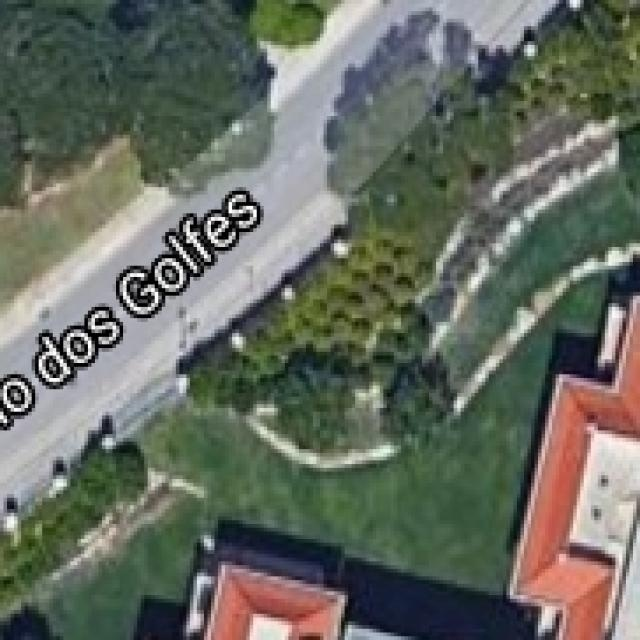

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, robo_token)

# Location of test set images
test_set_loc = dataset.location + f"/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
